In [23]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import numpy as np
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os


# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation of contextily (and by extension rasterio), you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [24]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100



In [25]:
df.head()


State            County                       City  \
0  New Jersey   Somerset County  South Bound Brook Borough   
1  New Jersey   Monmouth County     Monmouth Beach Borough   
2  New Jersey     Camden County        Chesilhurst Borough   
3  New Jersey   Somerset County           Watchung Borough   
4  New Jersey  Hunterdon County        Readington Township   

   Unemployment Rate (16 & Over)  Median Household Income  City Population  \
0                            8.4                    86667             4541   
1                            4.4                   111415             3226   
2                            6.3                    71875             1435   
3                            3.1                   140417             5963   
4                            5.5                   121885            15889   

   Uninsured Population  NUI, Under 6 years  NUI, 6-18 years  \
0                   432                  23               26   
1                   139                   0               12   
2                   124                   0                0   
3                    68                   0               16   
4                   299                   0                0   

   NUI, 19 to 25 years  ...  NUI, Men  NUI, Women  NUI, White  \
0                   28  ...       231         201         159   
1                    0  ...       111          28          82   
2                    0  ...       105          19          96   
3                    0  ...        37          31          66   
4                   68  ...       182         117         162   

   NUI, African American  NUI, American Indian & Alaska Natives  NUI, Asians  \
0                      0                                     17           62   
1                      0                                      0            0   
2                     16                                      0            0   
3                      2                                      0            0   
4                      0                                      0            9   

   NUI, Native Hawaiians & Pacific Islanders  NUI, Other Races  \
0                                          0               112   
1                                          0                28   
2                                          0                 0   
3                                          0                 0   
4                                          0                 7   

                                            geometry  % Uninsured  
0  POLYGON ((-74.54279 40.55520, -74.53715 40.558...     9.513323  
1  POLYGON ((-74.00319 40.33995, -74.00240 40.340...     4.308741  
2  POLYGON ((-74.89497 39.72492, -74.89114 39.734...     8.641115  
3  POLYGON ((-74.48232 40.62118, -74.46428 40.638...     1.140366  
4  POLYGON ((-74.86840 40.57530, -74.86086 40.576...     1.881805  

[5 rows x 25 columns]

In [26]:
df.shape

(559, 25)

In [27]:
tract_info.head()

State             County         Census Tract  \
0  New Jersey      Morris County  Census Tract 444.03   
1  New Jersey      Mercer County   Census Tract 30.09   
2  New Jersey      Bergen County     Census Tract 393   
3  New Jersey  Cumberland County  Census Tract 103.02   
4  New Jersey    Atlantic County  Census Tract 101.01   

   Unemployment Rate (16 & Over)  Median Household Income  City Population  \
0                            3.6                 141014.0           5313.0   
1                           11.5                  69052.0           5990.0   
2                            4.3                 128239.0           2675.0   
3                            5.6                  52837.0           1183.0   
4                            2.9                  98850.0           3270.0   

   Uninsured Population  NUI, Under 6 years  NUI, 6-18 years  \
0                 120.0                 0.0              0.0   
1                 444.0                 0.0             12.0   
2                 106.0                 0.0              6.0   
3                  55.0                 0.0             17.0   
4                  82.0                 0.0              0.0   

   NUI, 19 to 25 years  ...  NUI, Men  NUI, Women  NUI, White  \
0                  0.0  ...      70.0        50.0        95.0   
1                 45.0  ...     398.0        46.0       403.0   
2                  6.0  ...      55.0        51.0        72.0   
3                  0.0  ...      34.0        21.0        55.0   
4                  0.0  ...      73.0         9.0        81.0   

   NUI, African American  NUI, American Indian & Alaska Natives  NUI, Asians  \
0                    0.0                                    0.0          0.0   
1                   18.0                                    0.0         23.0   
2                    0.0                                    0.0          0.0   
3                    0.0                                    0.0          0.0   
4                    1.0                                    0.0          0.0   

   NUI, Native Hawaiians & Pacific Islanders  NUI, Other Races  \
0                                        0.0              25.0   
1                                        0.0               0.0   
2                                        0.0              34.0   
3                                        0.0               0.0   
4                                        0.0               0.0   

                                            geometry  % Uninsured  
0  POLYGON ((-74.54252 40.92796, -74.54081 40.930...     2.258611  
1  POLYGON ((-74.69241 40.21257, -74.68845 40.218...     7.412354  
2  POLYGON ((-74.26398 41.01427, -74.25753 41.016...     3.962617  
3  POLYGON ((-75.24288 39.28057, -75.24005 39.282...     4.649197  
4  POLYGON ((-74.40783 39.40556, -74.40551 39.407...     2.507645  

[5 rows x 25 columns]

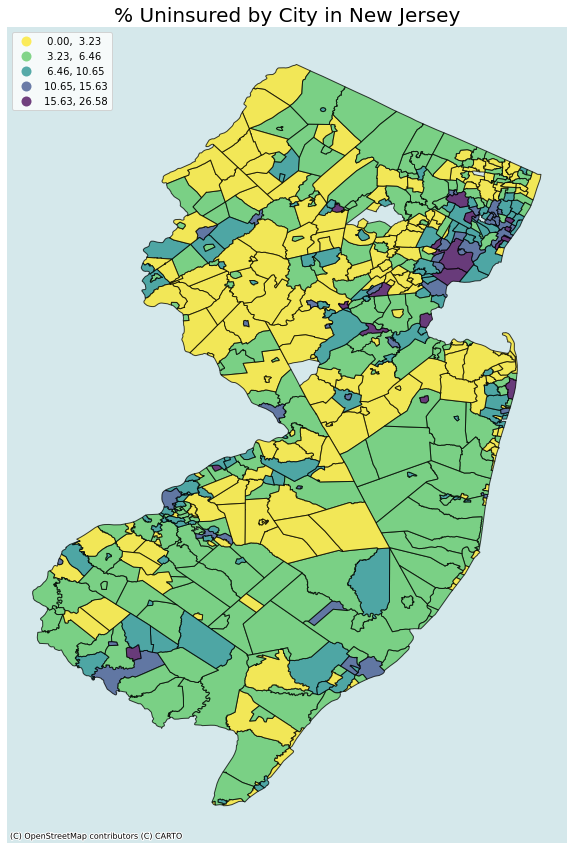

In [28]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

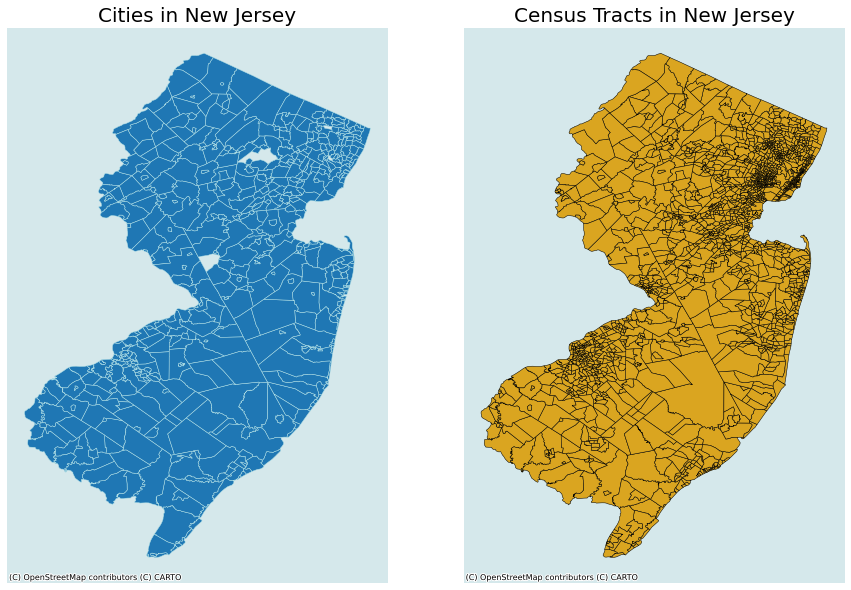

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

- In addition to geometric overlap, the values of each of the variables are also determined by whether the variable is **intensive** or **extensive**
    - Intensive Property: independent of size of system (Population Density, Concentration, Melting Point, etc.)

    - Extensive Property: dependent on size of system (Population Count, Mass, Volume, etc.)
    

- We are going to use data at the *city* level to predict data at the *census tract* level (a census tract is an area created for the purpose of taking a census)

In [30]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1809, 25)

In [31]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [32]:
# Create Uninsurance rate columns
col_dict = {
'NUI, Under 6 years': '% Uninsured, Under 6 years',
'NUI, 6-18 years': '% Uninsured, 6-18 years',
'NUI, 19 to 25 years': '% Uninsured, 19 to 25 years',
'NUI, 26 to 34 years': '% Uninsured, 26 to 34 years',
'NUI, 35 to 44 years': '% Uninsured, 35 to 44 years',
'NUI, 45 to 54 years': '% Uninsured, 45 to 54 years',
'NUI, 55 to 64 years': '% Uninsured, 55 to 64 years',
'NUI, 65 years and older': '% Uninsured, 65 years and older',
'NUI, Men': '% Uninsured, Men',
'NUI, Women': '% Uninsured, Women',
'NUI, White': '% Uninsured, White',
'NUI, African American': '% Uninsured, African American',
'NUI, American Indian & Alaska Natives': '% Uninsured, American Indian & Alaska Natives',
'NUI, Asians': '% Uninsured, Asians',
'NUI, Native Hawaiians & Pacific Islanders': '% Uninsured, Native Hawaiians & Pacific Islanders',
'NUI, Other Races': '% Uninsured, Other Races'}

percent_cols = list(col_dict.values())
numeric_cols = list(col_dict.keys())

results.shape

(1809, 21)

In [33]:
# Create % Uninsured Columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100

tract_info[percent_cols] = tract_info[numeric_cols].div(tract_info['Uninsured Population'], axis=0)
tract_info[percent_cols] = tract_info[percent_cols].apply(lambda x: x * 100)
results[percent_cols] = results[numeric_cols].div(results['Uninsured Population'], axis=0)
results[percent_cols] = results[percent_cols].apply(lambda x: x * 100)

# Calculate Model Residuals for % Uninsured
results['Residuals'] = tract_info['% Uninsured'] - results['% Uninsured']


In [34]:
tract_info.head()

State             County         Census Tract  \
0  New Jersey      Morris County  Census Tract 444.03   
1  New Jersey      Mercer County   Census Tract 30.09   
2  New Jersey      Bergen County     Census Tract 393   
3  New Jersey  Cumberland County  Census Tract 103.02   
4  New Jersey    Atlantic County  Census Tract 101.01   

   Unemployment Rate (16 & Over)  Median Household Income  City Population  \
0                            3.6                 141014.0           5313.0   
1                           11.5                  69052.0           5990.0   
2                            4.3                 128239.0           2675.0   
3                            5.6                  52837.0           1183.0   
4                            2.9                  98850.0           3270.0   

   Uninsured Population  NUI, Under 6 years  NUI, 6-18 years  \
0                 120.0                 0.0              0.0   
1                 444.0                 0.0             12.0   
2                 106.0                 0.0              6.0   
3                  55.0                 0.0             17.0   
4                  82.0                 0.0              0.0   

   NUI, 19 to 25 years  ...  % Uninsured, 55 to 64 years  \
0                  0.0  ...                     5.000000   
1                 45.0  ...                     5.180180   
2                  6.0  ...                    18.867925   
3                  0.0  ...                    14.545455   
4                  0.0  ...                    10.975610   

   % Uninsured, 65 years and older  % Uninsured, Men  % Uninsured, Women  \
0                             12.5         58.333333           41.666667   
1                              0.0         89.639640           10.360360   
2                              0.0         51.886792           48.113208   
3                              0.0         61.818182           38.181818   
4                              0.0         89.024390           10.975610   

   % Uninsured, White  % Uninsured, African American  \
0           79.166667                       0.000000   
1           90.765766                       4.054054   
2           67.924528                       0.000000   
3          100.000000                       0.000000   
4           98.780488                       1.219512   

   % Uninsured, American Indian & Alaska Natives  % Uninsured, Asians  \
0                                            0.0              0.00000   
1                                            0.0              5.18018   
2                                            0.0              0.00000   
3                                            0.0              0.00000   
4                                            0.0              0.00000   

   % Uninsured, Native Hawaiians & Pacific Islanders  % Uninsured, Other Races  
0                                                0.0                 20.833333  
1                                                0.0                  0.000000  
2                                                0.0                 32.075472  
3                                                0.0                  0.000000  
4                                                0.0                  0.000000  

[5 rows x 41 columns]

In [35]:
results.head()

Median Household Income  City Population  Uninsured Population  \
0             10077.418141      2073.954406             78.260887   
1              3689.873162      3930.434242            231.399440   
2             36269.790472      3300.360876            185.913942   
3             52837.000000      1183.000000             55.000000   
4             54154.603670      6243.714013            231.488303   

   NUI, Under 6 years  NUI, 6-18 years  NUI, 19 to 25 years  \
0            2.535097         2.616874             4.088866   
1            1.723477        15.057745            31.975030   
2            0.000000        31.330901             4.401862   
3            0.000000        17.000000             0.000000   
4            7.907986        12.940340            23.723957   

   NUI, 26 to 34 years  NUI, 35 to 44 years  NUI, 45 to 54 years  \
0            14.065698            18.072786            25.923408   
1            71.932480            54.561648            34.650955   
2            17.866382            50.750881            57.483141   
3            17.000000            10.000000             3.000000   
4            93.458011            44.572282            18.691602   

   NUI, 55 to 64 years  ...  % Uninsured, 65 years and older  \
0             9.731500  ...                         1.567398   
1            20.182821  ...                         0.568405   
2            12.946653  ...                         5.988858   
3             8.000000  ...                         0.000000   
4            30.194126  ...                         0.000000   

   % Uninsured, Men  % Uninsured, Women  % Uninsured, White  \
0         52.246604           47.753396           78.474399   
1         55.468444           44.531556           61.485692   
2         42.200557           57.799443           77.158774   
3         61.818182           38.181818          100.000000   
4         53.726708           46.273292           83.229814   

   % Uninsured, African American  \
0                       5.120167   
1                      22.383379   
2                       9.470752   
3                       0.000000   
4                       0.310559   

   % Uninsured, American Indian & Alaska Natives  % Uninsured, Asians  \
0                                            0.0             9.822362   
1                                            0.0             3.724030   
2                                            0.0             1.671309   
3                                            0.0             0.000000   
4                                            0.0             5.279503   

   % Uninsured, Native Hawaiians & Pacific Islanders  \
0                                           0.000000   
1                                           0.196002   
2                                           0.000000   
3                                           0.000000   
4                                           0.000000   

   % Uninsured, Other Races  Residuals  
0                  5.851620  -1.514900  
1                  8.859271   1.524978  
2                 11.699164  -1.670523  
3                  0.000000   0.000000  
4                  6.211180  -1.199896  

[5 rows x 39 columns]

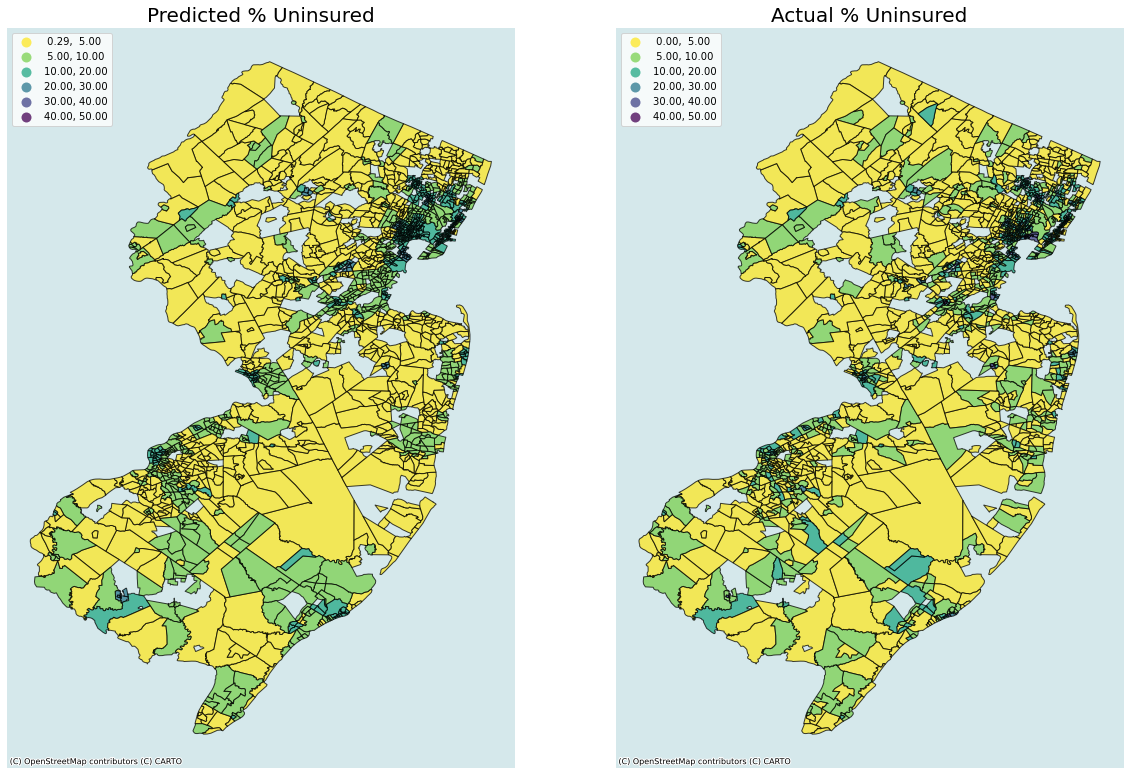

In [36]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

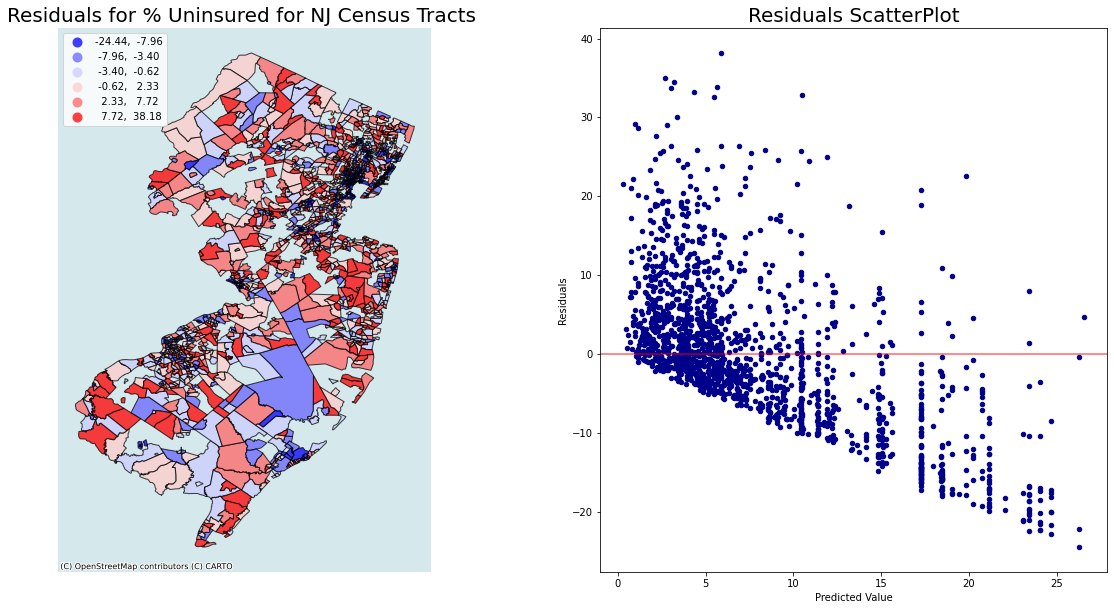

In [37]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 10))

# Build Predicted choropleth
results.plot(
    column='Residuals', 
    cmap="bwr", 
    scheme='quantiles',
    k=6,
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

# Residuals vs. Predicted Values
results.plot.scatter(x = '% Uninsured', y = 'Residuals', c = 'DarkBlue', ax=ax[1])
plt.axhline(y=0, color='r', linestyle='-', alpha = 0.6);
ax[1].set_xlabel('Predicted Value')
ax[1].set_ylabel('Residuals')

ax[0].set_title('Residuals for % Uninsured for NJ Census Tracts ',fontsize=20)
ax[1].set_title('Residuals ScatterPlot',fontsize=20)
ax[0].axis('off');

f.savefig('residuals.png')

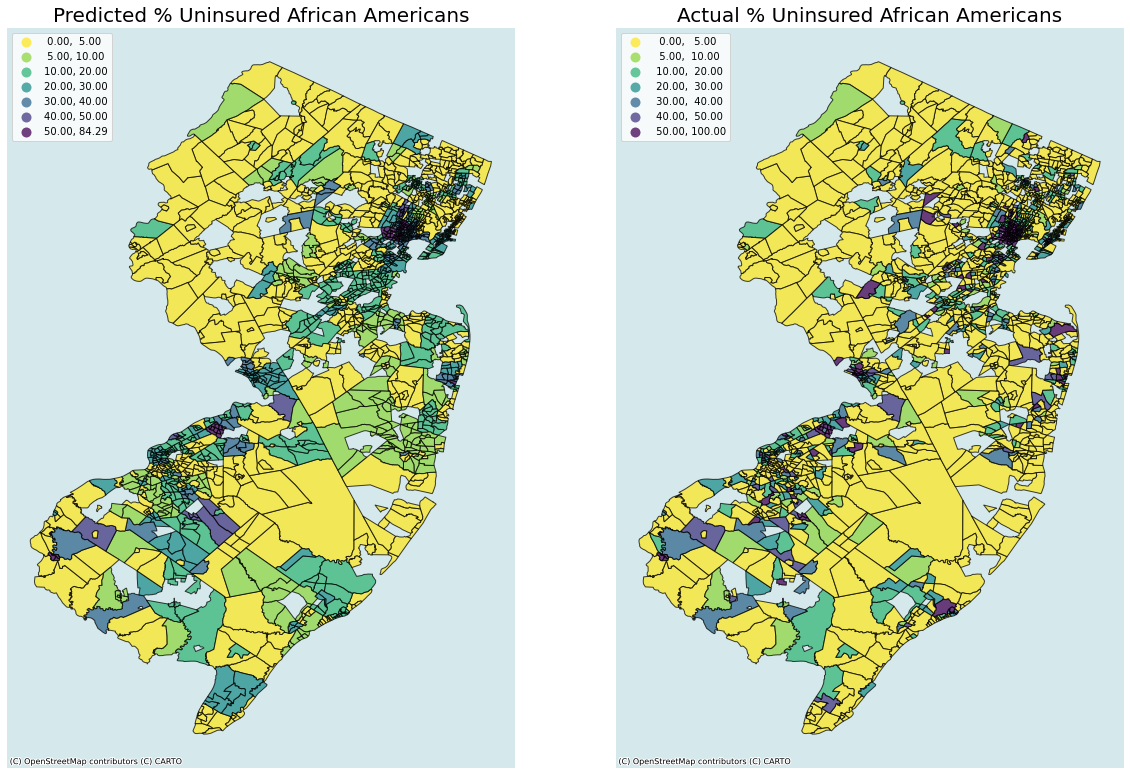

In [38]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured, African American', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured, African American', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

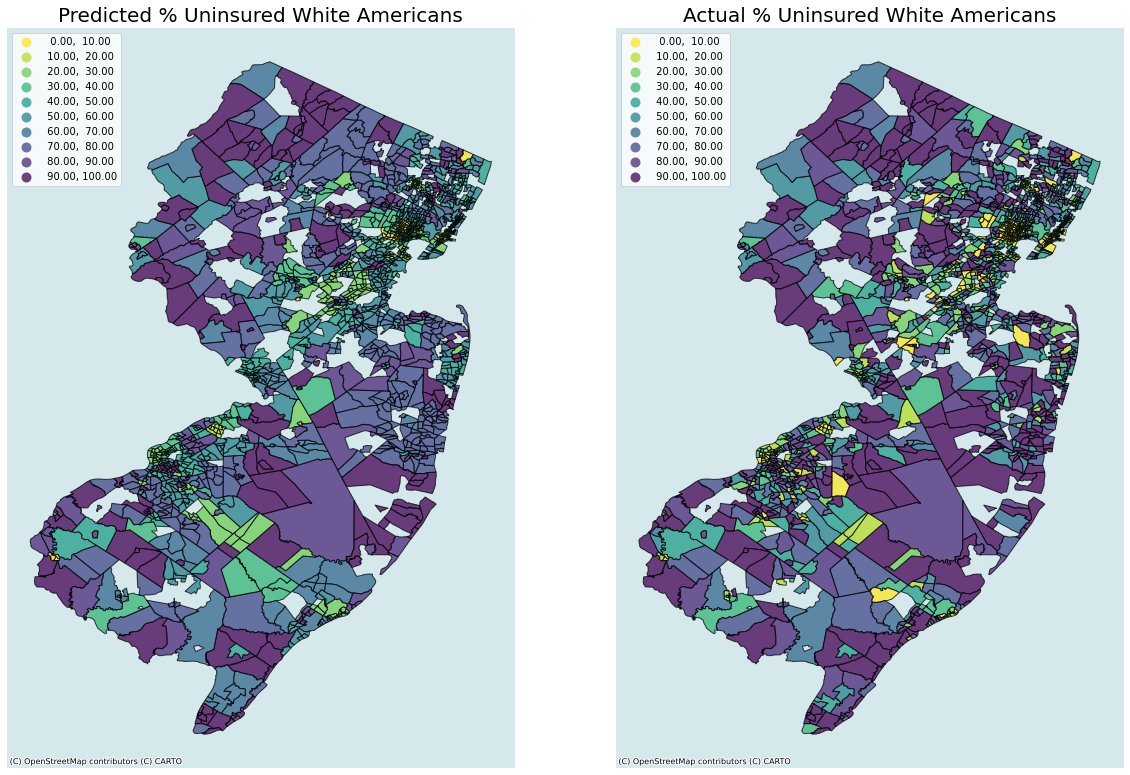

In [39]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured, White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured, White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [40]:
tract_info.head()

State             County         Census Tract  \
0  New Jersey      Morris County  Census Tract 444.03   
1  New Jersey      Mercer County   Census Tract 30.09   
2  New Jersey      Bergen County     Census Tract 393   
3  New Jersey  Cumberland County  Census Tract 103.02   
4  New Jersey    Atlantic County  Census Tract 101.01   

   Unemployment Rate (16 & Over)  Median Household Income  City Population  \
0                            3.6                 141014.0           5313.0   
1                           11.5                  69052.0           5990.0   
2                            4.3                 128239.0           2675.0   
3                            5.6                  52837.0           1183.0   
4                            2.9                  98850.0           3270.0   

   Uninsured Population  NUI, Under 6 years  NUI, 6-18 years  \
0                 120.0                 0.0              0.0   
1                 444.0                 0.0             12.0   
2                 106.0                 0.0              6.0   
3                  55.0                 0.0             17.0   
4                  82.0                 0.0              0.0   

   NUI, 19 to 25 years  ...  % Uninsured, 55 to 64 years  \
0                  0.0  ...                     5.000000   
1                 45.0  ...                     5.180180   
2                  6.0  ...                    18.867925   
3                  0.0  ...                    14.545455   
4                  0.0  ...                    10.975610   

   % Uninsured, 65 years and older  % Uninsured, Men  % Uninsured, Women  \
0                             12.5         58.333333           41.666667   
1                              0.0         89.639640           10.360360   
2                              0.0         51.886792           48.113208   
3                              0.0         61.818182           38.181818   
4                              0.0         89.024390           10.975610   

   % Uninsured, White  % Uninsured, African American  \
0           79.166667                       0.000000   
1           90.765766                       4.054054   
2           67.924528                       0.000000   
3          100.000000                       0.000000   
4           98.780488                       1.219512   

   % Uninsured, American Indian & Alaska Natives  % Uninsured, Asians  \
0                                            0.0              0.00000   
1                                            0.0              5.18018   
2                                            0.0              0.00000   
3                                            0.0              0.00000   
4                                            0.0              0.00000   

   % Uninsured, Native Hawaiians & Pacific Islanders  % Uninsured, Other Races  
0                                                0.0                 20.833333  
1                                                0.0                  0.000000  
2                                                0.0                 32.075472  
3                                                0.0                  0.000000  
4                                                0.0                  0.000000  

[5 rows x 41 columns]

In [41]:
# Create State, County, Census Tract, geometry merge table
merge_table = tract_info[['State','County','Census Tract','geometry']]
merge_table.head()

State             County         Census Tract  \
0  New Jersey      Morris County  Census Tract 444.03   
1  New Jersey      Mercer County   Census Tract 30.09   
2  New Jersey      Bergen County     Census Tract 393   
3  New Jersey  Cumberland County  Census Tract 103.02   
4  New Jersey    Atlantic County  Census Tract 101.01   

                                            geometry  
0  POLYGON ((-74.54252 40.92796, -74.54081 40.930...  
1  POLYGON ((-74.69241 40.21257, -74.68845 40.218...  
2  POLYGON ((-74.26398 41.01427, -74.25753 41.016...  
3  POLYGON ((-75.24288 39.28057, -75.24005 39.282...  
4  POLYGON ((-74.40783 39.40556, -74.40551 39.407...

In [42]:
# Add state, county, and census tract columns to results
results = results.merge(merge_table, how = 'inner', on = 'geometry')

# Add % Uninsured Column
results['% Uninsured'] = results['Uninsured Population']/results['City Population'] * 100

results.head()

Median Household Income  City Population  Uninsured Population  \
0             10077.418141      2073.954406             78.260887   
1              3689.873162      3930.434242            231.399440   
2             36269.790472      3300.360876            185.913942   
3             52837.000000      1183.000000             55.000000   
4             54154.603670      6243.714013            231.488303   

   NUI, Under 6 years  NUI, 6-18 years  NUI, 19 to 25 years  \
0            2.535097         2.616874             4.088866   
1            1.723477        15.057745            31.975030   
2            0.000000        31.330901             4.401862   
3            0.000000        17.000000             0.000000   
4            7.907986        12.940340            23.723957   

   NUI, 26 to 34 years  NUI, 35 to 44 years  NUI, 45 to 54 years  \
0            14.065698            18.072786            25.923408   
1            71.932480            54.561648            34.650955   
2            17.866382            50.750881            57.483141   
3            17.000000            10.000000             3.000000   
4            93.458011            44.572282            18.691602   

   NUI, 55 to 64 years  ...  % Uninsured, White  \
0             9.731500  ...           78.474399   
1            20.182821  ...           61.485692   
2            12.946653  ...           77.158774   
3             8.000000  ...          100.000000   
4            30.194126  ...           83.229814   

   % Uninsured, African American  \
0                       5.120167   
1                      22.383379   
2                       9.470752   
3                       0.000000   
4                       0.310559   

   % Uninsured, American Indian & Alaska Natives  % Uninsured, Asians  \
0                                            0.0             9.822362   
1                                            0.0             3.724030   
2                                            0.0             1.671309   
3                                            0.0             0.000000   
4                                            0.0             5.279503   

   % Uninsured, Native Hawaiians & Pacific Islanders  \
0                                           0.000000   
1                                           0.196002   
2                                           0.000000   
3                                           0.000000   
4                                           0.000000   

   % Uninsured, Other Races  Residuals       State             County  \
0                  5.851620  -1.514900  New Jersey      Morris County   
1                  8.859271   1.524978  New Jersey      Mercer County   
2                 11.699164  -1.670523  New Jersey      Bergen County   
3                  0.000000   0.000000  New Jersey  Cumberland County   
4                  6.211180  -1.199896  New Jersey    Atlantic County   

          Census Tract  
0  Census Tract 444.03  
1   Census Tract 30.09  
2     Census Tract 393  
3  Census Tract 103.02  
4  Census Tract 101.01  

[5 rows x 42 columns]

In [43]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']

In [44]:
# Import the model (for testing)
from joblib import load
model = load('areal interpolation joblib.model')
model.head()

Median Household Income  City Population  Uninsured Population  \
0             10077.418141      2073.954406             78.260887   
1              3689.873162      3930.434242            231.399440   
2             36269.790472      3300.360876            185.913942   
3             52837.000000      1183.000000             55.000000   
4             54154.603670      6243.714013            231.488303   

   NUI, Under 6 years  NUI, 6-18 years  NUI, 19 to 25 years  \
0            2.535097         2.616874             4.088866   
1            1.723477        15.057745            31.975030   
2            0.000000        31.330901             4.401862   
3            0.000000        17.000000             0.000000   
4            7.907986        12.940340            23.723957   

   NUI, 26 to 34 years  NUI, 35 to 44 years  NUI, 45 to 54 years  \
0            14.065698            18.072786            25.923408   
1            71.932480            54.561648            34.650955   
2            17.866382            50.750881            57.483141   
3            17.000000            10.000000             3.000000   
4            93.458011            44.572282            18.691602   

   NUI, 55 to 64 years  ...  % Uninsured, White  \
0             9.731500  ...           78.474399   
1            20.182821  ...           61.485692   
2            12.946653  ...           77.158774   
3             8.000000  ...          100.000000   
4            30.194126  ...           83.229814   

   % Uninsured, African American  \
0                       5.120167   
1                      22.383379   
2                       9.470752   
3                       0.000000   
4                       0.310559   

   % Uninsured, American Indian & Alaska Natives  % Uninsured, Asians  \
0                                            0.0             9.822362   
1                                            0.0             3.724030   
2                                            0.0             1.671309   
3                                            0.0             0.000000   
4                                            0.0             5.279503   

   % Uninsured, Native Hawaiians & Pacific Islanders  \
0                                           0.000000   
1                                           0.196002   
2                                           0.000000   
3                                           0.000000   
4                                           0.000000   

   % Uninsured, Other Races  Residuals       State             County  \
0                  5.851620  -1.514900  New Jersey      Morris County   
1                  8.859271   1.524978  New Jersey      Mercer County   
2                 11.699164  -1.670523  New Jersey      Bergen County   
3                  0.000000   0.000000  New Jersey  Cumberland County   
4                  6.211180  -1.199896  New Jersey    Atlantic County   

          Census Tract  
0  Census Tract 444.03  
1   Census Tract 30.09  
2     Census Tract 393  
3  Census Tract 103.02  
4  Census Tract 101.01  

[5 rows x 42 columns]

In [45]:
# Example plotly chloropleth for dashboard
import plotly.express as px
import json

# For geojson = you can also use geojson = model.__geo_interface__
fig = px.choropleth(model, geojson=json.loads(model.geometry.to_json()),locations=model.index, color="% Uninsured, White")
fig.update_geos(fitbounds="locations", visible=False)

fig.show()